In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/My\ Drive/University/UIU/11-Summer\ 2020/Pattern\ Lab/Colab\ Notebooks/Project\ Implementation/KDEF_frontal .

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P .

--2020-09-17 17:37:51--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘./haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.07s   

2020-09-17 17:37:52 (12.2 MB/s) - ‘./haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm,tqdm_notebook , notebook
import cv2
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
#!pip install --upgrade keras
from keras.layers import Dense, Dropout,BatchNormalization,ZeroPadding2D, Conv2D, MaxPooling2D, Flatten
from keras.layers import Concatenate
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from PIL import Image

In [ ]:
def getface(path):  
  #detect face in image, crop it then resize it then save it
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  img = cv2.imread(path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # to train colored
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # to train gray
  face = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in face:
    face_clip = gray[y:y+h, x:x+w]
    face_clip = cv2.resize(face_clip, (300,300))
    print ("raw data = ", face_clip)

    face_clip = np.stack((face_clip,)*3, axis=-1) # stack gray img to 3 channels
    return face_clip

In [ ]:
#checking for inconsistencies or mistakes in files

# folders=os.listdir('./KDEF_frontal') 
# for f in notebook.tqdm(folders):
#     sub_folders=os.listdir('./KDEF_frontal/'+f)
#     for sub_f in notebook.tqdm(sub_folders):
#         if (sub_f[6] != 'S'):
#             print(sub_folders)
#             break
        

In [ ]:
folders=os.listdir('./KDEF_frontal')
items=[]
ylabel=[]
count = 0

# AF: afraid, AN:angry,DI:disgusted, HA:happy, NE:neutral, SA:sad, SU:surprised
labels={'AF':0,'AN':1,'DI':2,'HA':3,'NE':4,'SA':5,'SU':6}   
for f in notebook.tqdm(folders):
    sub_folders=os.listdir('./KDEF_frontal/'+f)
    for sub_f in notebook.tqdm(sub_folders):
        print(sub_f)
        count += 1
        fpath="./KDEF_frontal/"+f+"/"+sub_f
        #files=set(os.listdir(fpath))  
        #print(f)

        try:    
            #i=cv2.imread(fpath+'/'+fl)
            #i = np.asarray(Image.open(fpath) )*1./255
            try:
                i = np.asarray(getface(fpath) )#*1./255
            except TypeError:
                print("error on: ", fpath)
                continue

            tag=sub_f[4:6]
            #print(tag)
            ylabel.append([labels[tag]])
            items.append(cv2.resize(i, (300,300)))    
            
        except KeyError:
            print(f)


items=np.asarray(items)
print(items.shape)
ylabel=np.vstack(ylabel)
print(np.shape(ylabel))

NameError: ignored

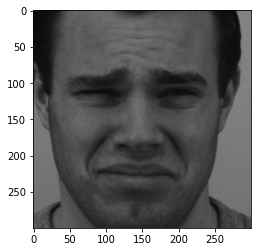

In [ ]:
plt.imshow(items[1])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#print(np.shape(items))
oneHotEnc = OneHotEncoder()
c=np.array([[0],[1],[2],[3],[4],[5],[6]])
oneHotEnc.fit(c)
ency=oneHotEnc.transform(ylabel)
ency.reshape(-1, 1)
xtrain, X_validate, ytrain, y_validate = train_test_split(items, ency, test_size=0.2, random_state=0)
#del items

#print(type(ytrain))
#print(type(y_validate))

ytrain = ytrain.todense()
y_validate = y_validate.todense()


tf.convert_to_tensor(xtrain, dtype=None, dtype_hint=None, name=None)
tf.convert_to_tensor(ytrain, dtype=None, dtype_hint=None, name=None)
tf.convert_to_tensor(X_validate, dtype=None, dtype_hint=None, name=None)
tf.convert_to_tensor(y_validate, dtype=None, dtype_hint=None, name=None)

<tf.Tensor: shape=(196, 7), dtype=float64, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])>

# VGG-16

In [ ]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(
  weights='imagenet',
  include_top=False,
  input_shape= (300,300,3)
)
def build_model(backbone):
  model = Sequential()
  model.add(backbone)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(7, activation='softmax')) #output_dim = 7
  
  model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
  )
  return model
  
vgg_top = build_model(vgg)

#earlyStop=EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0)

#vgg_top.fit(xtrain,ytrain,epochs=25,batch_size=16,validation_data=(X_validate,y_validate),callbacks=[earlyStop,check])

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg_top.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [ ]:
vgg_top.fit(xtrain,ytrain,epochs=75,batch_size=16,validation_data=(X_validate,y_validate))

Epoch 1/75
49/49 [==============================] - 42s 863ms/step - loss: 2.1396 - acc: 0.1416 - val_loss: 4.1515 - val_acc: 0.1684
Epoch 2/75
49/49 [==============================] - 41s 841ms/step - loss: 2.0649 - acc: 0.1454 - val_loss: 2.6981 - val_acc: 0.1224
Epoch 3/75
49/49 [==============================] - 41s 840ms/step - loss: 2.0509 - acc: 0.1365 - val_loss: 2.1071 - val_acc: 0.1633
Epoch 4/75
49/49 [==============================] - 41s 836ms/step - loss: 2.0135 - acc: 0.1288 - val_loss: 2.1292 - val_acc: 0.1224
Epoch 5/75
49/49 [==============================] - 41s 832ms/step - loss: 2.0116 - acc: 0.1403 - val_loss: 2.6786 - val_acc: 0.1684
Epoch 6/75
49/49 [==============================] - 41s 829ms/step - loss: 2.0014 - acc: 0.1671 - val_loss: 2.0895 - val_acc: 0.1684
Epoch 7/75
49/49 [==============================] - 41s 829ms/step - loss: 1.9937 - acc: 0.1531 - val_loss: 1.9585 - val_acc: 0.1327
Epoch 8/75
49/49 [==============================] - 41s 832ms/step - 

In [ ]:
vgg_top.fit(xtrain,ytrain,epochs=25,batch_size=16,validation_data=(X_validate,y_validate)) # train few more epochs

Epoch 1/25
49/49 [==============================] - 40s 820ms/step - loss: 0.1445 - acc: 0.9426 - val_loss: 0.6656 - val_acc: 0.7653
Epoch 2/25
49/49 [==============================] - 40s 817ms/step - loss: 0.1595 - acc: 0.9515 - val_loss: 0.6614 - val_acc: 0.7704
Epoch 3/25
49/49 [==============================] - 40s 814ms/step - loss: 0.2053 - acc: 0.9286 - val_loss: 0.6983 - val_acc: 0.7857
Epoch 4/25
49/49 [==============================] - 40s 815ms/step - loss: 0.1609 - acc: 0.9515 - val_loss: 0.7753 - val_acc: 0.8010
Epoch 5/25
49/49 [==============================] - 40s 814ms/step - loss: 0.1045 - acc: 0.9630 - val_loss: 0.6817 - val_acc: 0.8061
Epoch 6/25
49/49 [==============================] - 40s 814ms/step - loss: 0.0922 - acc: 0.9707 - val_loss: 0.7964 - val_acc: 0.7653
Epoch 7/25
49/49 [==============================] - 40s 813ms/step - loss: 0.0959 - acc: 0.9656 - val_loss: 0.8003 - val_acc: 0.8112
Epoch 8/25
49/49 [==============================] - 40s 814ms/step - 

In [ ]:
vgg_top.save('vgg-frontal-crop2.hdf5') 
vgg_top = load_model("vgg-frontal-crop2.hdf5")
vgg_top.evaluate(X_validate,y_validate)

7/7 [==============================] - 2s 334ms/step - loss: 0.8706 - acc: 0.8112


[0.8706097602844238, 0.8112244606018066]

## ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape= (300,300,3),
    )

def build_model(backbone):
  model = Sequential()
  model.add(backbone)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(7, activation='softmax')) #output_dim = 7
  
  model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
  )
  return model
resnet_top = build_model(resnet)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_top.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               104858112 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [ ]:
resnet_top.fit(xtrain,ytrain,epochs=75,batch_size=16,validation_data=(X_validate,y_validate))

Epoch 1/75
49/49 [==============================] - 10s 202ms/step - loss: 1.6532 - acc: 0.3686 - val_loss: 115.9323 - val_acc: 0.1837
Epoch 2/75
49/49 [==============================] - 9s 183ms/step - loss: 1.0578 - acc: 0.6224 - val_loss: 3.9386 - val_acc: 0.3112
Epoch 3/75
49/49 [==============================] - 9s 184ms/step - loss: 0.9593 - acc: 0.6645 - val_loss: 5.0747 - val_acc: 0.1735
Epoch 4/75
49/49 [==============================] - 9s 184ms/step - loss: 0.9538 - acc: 0.6505 - val_loss: 266.1578 - val_acc: 0.1480
Epoch 5/75
49/49 [==============================] - 9s 184ms/step - loss: 0.6261 - acc: 0.7946 - val_loss: 2.8576 - val_acc: 0.2857
Epoch 6/75
49/49 [==============================] - 9s 183ms/step - loss: 0.5078 - acc: 0.8099 - val_loss: 2.0614 - val_acc: 0.3571
Epoch 7/75
49/49 [==============================] - 9s 183ms/step - loss: 0.4464 - acc: 0.8508 - val_loss: 2.0595 - val_acc: 0.4388
Epoch 8/75
49/49 [==============================] - 9s 183ms/step - los

In [ ]:
resnet_top.fit(xtrain,ytrain,epochs=25,batch_size=16,validation_data=(X_validate,y_validate)) # train few more epochs

Epoch 1/25
49/49 [==============================] - 9s 184ms/step - loss: 4.6029e-04 - acc: 1.0000 - val_loss: 0.8547 - val_acc: 0.8571
Epoch 2/25
49/49 [==============================] - 9s 184ms/step - loss: 0.0242 - acc: 0.9949 - val_loss: 1.0094 - val_acc: 0.8367
Epoch 3/25
49/49 [==============================] - 9s 183ms/step - loss: 0.0243 - acc: 0.9949 - val_loss: 1.1489 - val_acc: 0.7857
Epoch 4/25
49/49 [==============================] - 9s 184ms/step - loss: 0.0226 - acc: 0.9923 - val_loss: 1.8033 - val_acc: 0.6735
Epoch 5/25
49/49 [==============================] - 9s 184ms/step - loss: 0.0329 - acc: 0.9923 - val_loss: 1.4047 - val_acc: 0.7143
Epoch 6/25
49/49 [==============================] - 9s 184ms/step - loss: 0.1065 - acc: 0.9745 - val_loss: 1.1404 - val_acc: 0.7500
Epoch 7/25
49/49 [==============================] - 9s 183ms/step - loss: 0.1468 - acc: 0.9592 - val_loss: 1.5675 - val_acc: 0.6837
Epoch 8/25
49/49 [==============================] - 9s 183ms/step - loss

In [ ]:
resnet_top.save('resnet-frontal-crop2.hdf5') 
resnet_top = load_model("resnet-frontal-crop2.hdf5")
resnet_top.evaluate(X_validate, y_validate)

7/7 [==============================] - 0s 71ms/step - loss: 1.5919 - acc: 0.6786


[1.591941237449646, 0.6785714030265808]